# Lab3AI工程程式與實作 - 資料預測 &深度學習模型

# Lab 3-5 應用實作: 微笑檢測應用於使用者滿意分析

## 數據集分割 (訓練、驗證、測試)

## 卷積神經網絡(CNN)的應用與專案實作 - 微笑偵測 (Smile Detection)

In [93]:
#1401 連接☁雲端硬碟，連結時需要一些時間是正常的, # 課程所練習的檔案就不會消失囉
from google.colab import drive

%cd '/content/drive/MyDrive/PEA2022'


/content/drive/MyDrive/PEA2022


In [94]:
!pwd

/content/drive/MyDrive/PEA2022


## 1. 從github網站下載數據集, around 5-min

In [95]:
!git clone https://github.com/Grace-TA/SMILEsmileD.git

Cloning into 'SMILEsmileD'...
remote: Enumerating objects: 13190, done.
remote: Total 13190 (delta 0), reused 0 (delta 0), pack-reused 13190
Receiving objects: 100% (13190/13190), 37.48 MiB | 7.55 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (13180/13180), done.


## 2. 安裝資料夾 樹狀結構工具

In [31]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


### Mission 1: 顯示資料夾 樹狀結構, 確定完成資料的下載;並更新到你的GitHub實作中

In [131]:
!tree SMILEsmileD -L 3
print('Done by TA Grace')

SMILEsmileD
├── appz
│   ├── smileD.c
│   └── sorter.c
├── README
├── smileD
│   ├── smiled_01.xml
│   ├── smiled_02.xml
│   ├── smiled_03.xml
│   ├── smiled_04.xml
│   └── smiled_05.xml
└── SMILEs
    ├── negatives
    │   ├── negatives7
    │   └── smiles_01_neg.idx
    └── positives
        ├── positives7
        ├── smiles_01_pos.idx
        ├── smiles_02_pos.idx
        ├── smiles_03_pos.idx
        ├── smiles_04_pos.idx
        └── smiles_05_pos.idx

7 directories, 14 files
Done by TA Grace


In [33]:
# 沒有微笑(負向)圖片數量
%%time
from imutils import paths #路徑檔案管理
neg_images = sorted(list(paths.list_images('SMILEsmileD/SMILEs/negatives/negatives7'))) 
print(len(neg_images))

9475
CPU times: user 25 ms, sys: 10.5 ms, total: 35.5 ms
Wall time: 35.9 ms


In [34]:
# 微笑(正向)圖片數量
pos_images = sorted(list(paths.list_images('SMILEsmileD/SMILEs/positives/positives7'))) 
print(len(pos_images))

3690


## A. 數據集分割 - 兩個分類檔案 *** 取相同數量 ***

In [35]:
neg_images = neg_images[:3690]
print('微笑數:', len(neg_images))
print('不微笑數:', len(pos_images))
print('總數:', len(neg_images) + len(pos_images))

微笑數: 3690
不微笑數: 3690
總數: 7380


### 很重要: 製作數據集 [圖片路徑,label] 微笑:1 沒微笑:0

In [60]:
dataset = [(path, 0) for path in neg_images] + [(path, 1) for path in pos_images]

print('Dataset Size: ',len(dataset))

print('Check content: ', dataset[-2])



Dataset Size:  7380
Check content:  ('SMILEsmileD/SMILEs/positives/positives7/9997.jpg', 1)


In [63]:
dataset[:5]

[('SMILEsmileD/SMILEs/negatives/negatives7/10.jpg', 0),
 ('SMILEsmileD/SMILEs/negatives/negatives7/10000.jpg', 0),
 ('SMILEsmileD/SMILEs/negatives/negatives7/10001.jpg', 0),
 ('SMILEsmileD/SMILEs/negatives/negatives7/10002.jpg', 0),
 ('SMILEsmileD/SMILEs/negatives/negatives7/10003.jpg', 0)]

In [65]:
dataset[-5:]

[('SMILEsmileD/SMILEs/positives/positives7/9991.jpg', 1),
 ('SMILEsmileD/SMILEs/positives/positives7/9992.jpg', 1),
 ('SMILEsmileD/SMILEs/positives/positives7/9994.jpg', 1),
 ('SMILEsmileD/SMILEs/positives/positives7/9997.jpg', 1),
 ('SMILEsmileD/SMILEs/positives/positives7/9998.jpg', 1)]

Check content:  ('SMILEsmileD/SMILEs/positives/positives7/9997.jpg', 1)


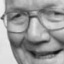

In [47]:
# Smile
print('Check content: ', dataset[-2])
from IPython.display import Image
Image(dataset[-2][0],width=200)


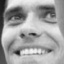

In [56]:
# Smile
Image(dataset[-2000][0],width=200)

Check content:  ('SMILEsmileD/SMILEs/negatives/negatives7/10001.jpg', 0)


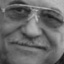

In [48]:
# No Smile

print('Check content: ', dataset[2])
from IPython.display import Image
Image(dataset[2][0],width=200)

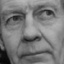

In [55]:
# No Smile

Image(dataset[2000][0],width=200)

### 載入需要的Python模組

In [68]:
#%tensorflow_version 1.x
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.io import imread #skimage python影像處理模組
from skimage.measure import block_reduce

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split

print("Done by TA Grace")

Done by TA Grace


### 將所有圖片轉成矩陣

In [ ]:
%%time
x_train = []
y_train = []
count=0
for path,label in dataset:
    image = cv2.imread(path) #載入圖片
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #轉灰階
    image = cv2.resize(image,(180,192)) #統一圖片尺寸
    # 3x3局部採樣取平均值 類似池化層 減少數據量 
    image = block_reduce(image, block_size=(3, 3), func=np.mean) 
    x_train.append(image)
    y_train.append(label)
    count=count+1
    if count % 50 == 0:
        print(count,'處理完成..',label)


In [70]:
#4631 list轉成np矩陣不產生副本
x_train = np.asarray(x_train) 
y_train = np.asarray(y_train)

In [96]:
# 存成numpy format
np.save('x_train_vnu', x_train)
np.save('y_train_vnu', y_train)

# Chec the saved files?
!ls

Lab3_20221002.ipynb	   sales
Lab3_SmileD20221023.ipynb  SMILEsmileD
mnist_png		   x_train_vnu.npy
mnist_png.tar.gz	   y_train_vnu.npy
mnist_test.csv		   課程互動_職資工四系4甲_Fall2022.gsheet


In [83]:
# 載入numpy file
x_train = np.load('x_train_vnu.npy')
y_train = np.load('y_train_vnu.npy')

### 標準化成0~1浮點數

In [73]:
x_train = x_train.astype(np.float32) / 255. #標準化
y_train = y_train.astype(np.int32)
print (x_train.dtype, x_train.min(), x_train.max(), x_train.shape)
print (y_train.dtype, y_train.min(), y_train.max(), y_train.shape)

float32 0.0 1.0 (7380, 64, 60)
int32 0 1 (7380,)


### 資料預處理, 標籤轉 one hot, 隨機打亂順序 (Shuffle: 洗牌)

In [74]:
# 資料預處理

from keras.utils import np_utils
number_of_categories = 2 #分類數
# 標籤轉 one hot
y_train = np_utils.to_categorical(y_train, number_of_categories).astype(np.float32)

#隨機打亂順序
indices = np.arange(len(x_train))
temp_x = x_train
temp_y = y_train
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

### 顯示訓練數據與標籤

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


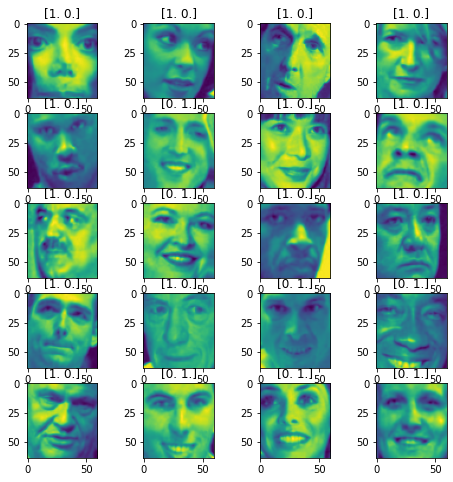

In [75]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = x_train[i]
    fig.add_subplot(rows, columns, i)
    plt.title(y_train[i])
    plt.imshow(img)
plt.show()

分割20%成為測試集

In [76]:
x_train = np.expand_dims(x_train, axis=-1)
# 分割20%成為測試集
(trainX, testX, trainY, testY) = train_test_split(x_train, y_train, test_size=0.20, random_state=1)
print(trainX.shape)

(5904, 64, 60, 1)


建模

In [77]:
filters = 32
conv_size = 3 #卷積 3*3
pool_size = 2 #池化 2*2

model = Sequential()
model.add(layers.Conv2D(filters,(conv_size,conv_size),activation="relu",input_shape=trainX.shape[1:]))
model.add(layers.MaxPooling2D((pool_size,pool_size)))
model.add(layers.Conv2D(filters*2,(conv_size,conv_size),activation="relu"))
model.add(layers.MaxPooling2D((pool_size,pool_size)))
model.add(layers.Conv2D(filters,(conv_size,conv_size),activation="relu"))
model.add(layers.MaxPooling2D((pool_size,pool_size)))
model.add(layers.Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(number_of_categories, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 58, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 27, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 11, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 5, 32)         0

### 模型編譯與訓練 (大約10分鐘)

In [78]:
%%time
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(trainX, trainY, epochs=10)

Epoch 1/10
185/185 [==============================] - 33s 175ms/step - loss: 0.5061 - accuracy: 0.7381
Epoch 2/10
185/185 [==============================] - 34s 182ms/step - loss: 0.3337 - accuracy: 0.8569
Epoch 3/10
185/185 [==============================] - 35s 187ms/step - loss: 0.2897 - accuracy: 0.8825
Epoch 4/10
185/185 [==============================] - 34s 185ms/step - loss: 0.2654 - accuracy: 0.8948
Epoch 5/10
185/185 [==============================] - 34s 185ms/step - loss: 0.2472 - accuracy: 0.9001
Epoch 6/10
185/185 [==============================] - 37s 201ms/step - loss: 0.2279 - accuracy: 0.9085
Epoch 7/10
185/185 [==============================] - 31s 167ms/step - loss: 0.2131 - accuracy: 0.9165
Epoch 8/10
185/185 [==============================] - 34s 187ms/step - loss: 0.1986 - accuracy: 0.9238
Epoch 9/10
185/185 [==============================] - 30s 160ms/step - loss: 0.1875 - accuracy: 0.9267
Epoch 10/10
185/185 [==============================] - 29s 156ms/step - l

### 每次都要訓練嗎? 儲存模型(下次就可以使用訓練的成果)

In [97]:
model.save('smile_vnu.h5')
!ls

Lab3_20221002.ipynb	   SMILEsmileD
Lab3_SmileD20221023.ipynb  smile_vnu.h5
mnist_png		   x_train_vnu.npy
mnist_png.tar.gz	   y_train_vnu.npy
mnist_test.csv		   課程互動_職資工四系4甲_Fall2022.gsheet
sales


In [84]:
#3501 模型評估
score = model.evaluate(testX, testY)
print('Test score:', score[0])
print('Test accuracy:', score[1])

47/47 [==============================] - 2s 37ms/step - loss: 0.3165 - accuracy: 0.8787
Test score: 0.3165249526500702
Test accuracy: 0.8787263035774231


dict_keys(['loss', 'accuracy'])


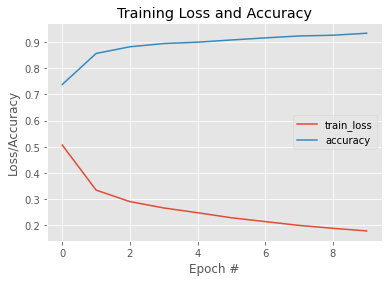

In [85]:
#3601 繪製訓練歷程圖表 accuracy不能只寫acc
history_dict = history.history
print(history_dict.keys())
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["accuracy"], label="accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## Mission 2: 實測數據!! 最後可試著到網路找3張微笑或不微笑的臉來試試

In [102]:
!pwd
!ls

/content/drive/MyDrive/PEA2022
Lab3_20221002.ipynb	   Smile.png
Lab3_SmileD20221023.ipynb  SMILEsmileD
mnist_png		   smile_vnu.h5
mnist_png.tar.gz	   x_train_vnu.npy
mnist_test.csv		   y_train_vnu.npy
sales			   課程互動_職資工四系4甲_Fall2022.gsheet


### 可以將電腦的圖, 用Colab上傳到Google Drive

https://youtu.be/i9gaktn2SD4

https://github.com/Grace-TA/PEA2022/blob/main/Reference/Smile.png




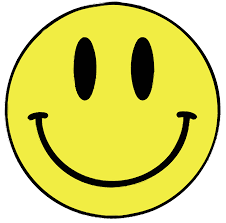

In [124]:
#3644 顯示圖片 微笑
from IPython.display import Image
fname = './Smile.png'
Image(fname, width=200)


In [119]:
#4647 人臉圖片預測微笑

def DetectSmile(fn): # Rewrite by Horace, 2022.10.23
  test_images = []
  t_image = cv2.imread(fn) #2000 1000 
  t_image = cv2.cvtColor(t_image, cv2.COLOR_BGR2GRAY)
  t_image = cv2.resize(t_image,(60,64))
  test_images.append(t_image)

  plt.imshow(t_image)
  test_images = np.asarray(test_images)
  test_images = test_images.astype(np.float32) / 255.

  test_images = np.expand_dims(test_images, axis=-1)
  p = model.predict(np.array([test_images[0]]))[0]

  print(p)
  class_names = ["Neutral:中性","Smiling:微笑"]
  bar_width = 50 #刻度寬度
  left_count = int(p[1] * bar_width) #使用Smiling決定 左邊刻度
  right_count = bar_width - left_count 
  left_side = '-' * left_count #顯示左邊長度
  right_side = '-' * right_count #顯示右邊長度
  print (class_names[0], left_side + '<|>' + right_side, class_names[1])


Done by TA Grace
1/1 [==============================] - 0s 17ms/step
[8.636706e-11 1.000000e+00]
Neutral:中性 --------------------------------------------------<|> Smiling:微笑


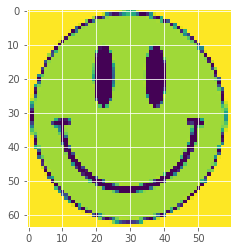

In [120]:
## Main program for smile detection
print('Done by TA Grace')
fname = './Smile.png'
DetectSmile(fname)

In [113]:
!ls

Lab3_20221002.ipynb	   NoSmile2.jpg  smile_vnu.h5
Lab3_SmileD20221023.ipynb  sales	 x_train_vnu.npy
mnist_png		   smile2.jfif	 y_train_vnu.npy
mnist_png.tar.gz	   Smile.png	 課程互動_職資工四系4甲_Fall2022.gsheet
mnist_test.csv		   SMILEsmileD


Done by TA Grace
1/1 [==============================] - 0s 18ms/step
[0.9837605  0.01623953]
Neutral:中性 <|>-------------------------------------------------- Smiling:微笑


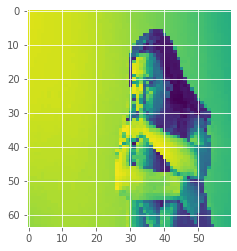

In [129]:
fname = './NoSmile2.jpg'
print('Done by TA Grace')
DetectSmile(fname)

Done by TA Grace
1/1 [==============================] - 0s 21ms/step
[0.729704 0.270296]
Neutral:中性 -------------<|>------------------------------------- Smiling:微笑


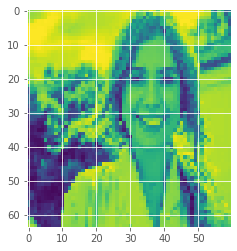

In [128]:
fname = './smile2.jfif'
print('Done by TA Grace')
DetectSmile(fname)